In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:
def data_loader(folder_dir):
    image_dataset = []
    for images in os.listdir(folder_dir):
        image = cv2.imread(folder_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image_dataset.append(image)
         
    return image_dataset

In [3]:
image=cv2.imread("C:/Users/susha/Dropbox/My PC (LAPTOP-46V5QLMG)/Desktop/Programs/UNet/dataset/images",1)

In [4]:
image_dataset=data_loader("C:/Users/susha/Dropbox/My PC (LAPTOP-46V5QLMG)/Desktop/Programs/UNet/dataset/images")

In [5]:

len(image_dataset)

400

In [6]:
mask_dataset=data_loader("C:/Users/susha/Dropbox/My PC (LAPTOP-46V5QLMG)/Desktop/Programs/UNet/dataset/label_images")

In [7]:
mask_labels=pd.read_csv("C:/Users/susha/Dropbox/My PC (LAPTOP-46V5QLMG)/Desktop/Programs/UNet/dataset/class_dict.csv")

In [8]:
mask_dataset[0].shape

(128, 128, 3)

In [9]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

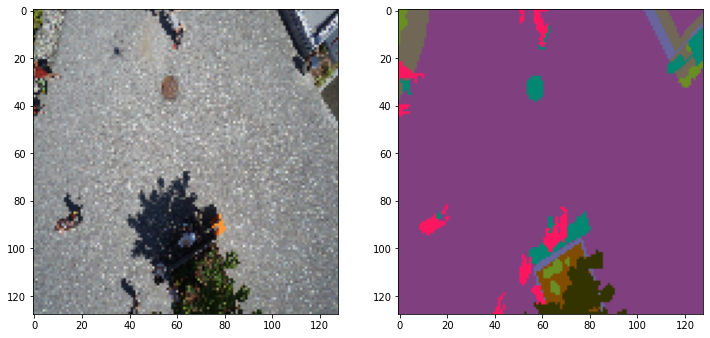

In [10]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image_dataset[0])
plt.subplot(122)
plt.imshow(mask_dataset[0])
plt.show()


In [11]:
mask_labels

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [12]:
# converting 3 values (RGB) to 1 label values...
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels...
    return label_seg

In [13]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels) # calling rgb to labels for each images...
    labels.append(label)

In [14]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [15]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22], dtype=uint8)

In [16]:
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=23)

In [17]:
print(labels.shape)
print(labels_cat.shape)

(400, 128, 128, 1)
(400, 128, 128, 23)


In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(image_dataset,labels_cat,test_size=0.2,random_state=42)

In [19]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [20]:
BACKBONE = 'resnet34' 
preprocess_input = sm.get_preprocessing(BACKBONE)

In [21]:
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)


In [23]:
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=23, activation='softmax')

85521592/85521592 [==============================] - 937s 11us/step


In [24]:

model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
model_resnet_backbone.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

                                                                                                  
 stage1_unit3_bn1 (BatchNormali  (None, None, None,   256        ['add_1[0][0]']                  
 zation)                        64)                                                               
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, None, None,   0          ['stage1_unit3_bn1[0][0]']       
 )                              64)                                                               
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, None, None,   0          ['stage1_unit3_relu1[0][0]']     
 D)                             64)                                                               
                                                                                                  
 stage1_un

                                128)                              'add_3[0][0]']                  
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, None, None,   512        ['add_4[0][0]']                  
 zation)                        128)                                                              
                                                                                                  
 stage2_unit3_relu1 (Activation  (None, None, None,   0          ['stage2_unit3_bn1[0][0]']       
 )                              128)                                                              
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, None, None,   0          ['stage2_unit3_relu1[0][0]']     
 2D)                            128)                                                              
          

 add_7 (Add)                    (None, None, None,   0           ['stage3_unit1_conv2[0][0]',     
                                256)                              'stage3_unit1_sc[0][0]']        
                                                                                                  
 stage3_unit2_bn1 (BatchNormali  (None, None, None,   1024       ['add_7[0][0]']                  
 zation)                        256)                                                              
                                                                                                  
 stage3_unit2_relu1 (Activation  (None, None, None,   0          ['stage3_unit2_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, None, None,   0          ['stage3_unit2_relu1[0][0]']     
 2D)      

                                                                                                  
 stage3_unit5_bn1 (BatchNormali  (None, None, None,   1024       ['add_10[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit5_relu1 (Activation  (None, None, None,   0          ['stage3_unit5_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_24 (ZeroPadding  (None, None, None,   0          ['stage3_unit5_relu1[0][0]']     
 2D)                            256)                                                              
                                                                                                  
 stage3_un

                                512)                              'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, None, None,   2048       ['add_13[0][0]']                 
 zation)                        512)                                                              
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, None, None,   0          ['stage4_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 zero_padding2d_30 (ZeroPadding  (None, None, None,   0          ['stage4_unit2_relu1[0][0]']     
 2D)                            512)                                                              
          

                                                                                                  
 decoder_stage0b_relu (Activati  (None, None, None,   0          ['decoder_stage0b_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, None, None,   0          ['decoder_stage0b_relu[0][0]']   
 ampling2D)                     256)                                                              
                                                                                                  
 decoder_stage1_concat (Concate  (None, None, None,   0          ['decoder_stage1_upsampling[0][0]
 nate)                          384)                             ',                               
                                                                  'stage3_unit1_relu1[0][0]']     
          

                                16)                              ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, None, None,   64         ['decoder_stage4a_conv[0][0]']   
 lization)                      16)                                                               
                                                                                                  
 decoder_stage4a_relu (Activati  (None, None, None,   0          ['decoder_stage4a_bn[0][0]']     
 on)                            16)                                                               
                                                                                                  
 decoder_stage4b_conv (Conv2D)  (None, None, None,   2304        ['decoder_stage4a_relu[0][0]']   
                                16)                                                               
          

In [26]:
history = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Epoch 1/100
20/20 [==============================] - 69s 3s/step - loss: 2.5041 - accuracy: 0.3391 - val_loss: 2358.1636 - val_accuracy: 0.2158
Epoch 2/100
20/20 [==============================] - 51s 3s/step - loss: 1.6766 - accuracy: 0.5570 - val_loss: 338.4882 - val_accuracy: 0.3789
Epoch 3/100
20/20 [==============================] - 50s 2s/step - loss: 1.4098 - accuracy: 0.6033 - val_loss: 5305.7993 - val_accuracy: 0.3553
Epoch 4/100
20/20 [==============================] - 48s 2s/step - loss: 1.2961 - accuracy: 0.6241 - val_loss: 124.6092 - val_accuracy: 0.3671
Epoch 5/100
20/20 [==============================] - 50s 3s/step - loss: 1.2765 - accuracy: 0.6259 - val_loss: 1.9337 - val_accuracy: 0.5187
Epoch 6/100
20/20 [==============================] - 49s 2s/step - loss: 1.1865 - accuracy: 0.6523 - val_loss: 2.0166 - val_accuracy: 0.5316
Epoch 7/100
20/20 [==============================] - 49s 2s/step - loss: 1.1297 - accuracy: 0.6686 - val_loss: 13.7243 - val_accuracy: 0.4659
Ep

20/20 [==============================] - 47s 2s/step - loss: 0.4781 - accuracy: 0.8535 - val_loss: 0.8496 - val_accuracy: 0.7686
Epoch 59/100
20/20 [==============================] - 47s 2s/step - loss: 0.4801 - accuracy: 0.8543 - val_loss: 1.2656 - val_accuracy: 0.6937
Epoch 60/100
20/20 [==============================] - 34069s 3s/step - loss: 0.4816 - accuracy: 0.8524 - val_loss: 1.1069 - val_accuracy: 0.7474
Epoch 61/100
20/20 [==============================] - 47s 2s/step - loss: 0.4558 - accuracy: 0.8609 - val_loss: 0.9025 - val_accuracy: 0.7697
Epoch 62/100
20/20 [==============================] - 47s 2s/step - loss: 0.4120 - accuracy: 0.8752 - val_loss: 0.8269 - val_accuracy: 0.7789
Epoch 63/100
20/20 [==============================] - 49s 2s/step - loss: 0.3990 - accuracy: 0.8790 - val_loss: 0.7515 - val_accuracy: 0.7964
Epoch 64/100
20/20 [==============================] - 48s 2s/step - loss: 0.3966 - accuracy: 0.8803 - val_loss: 0.8104 - val_accuracy: 0.7804
Epoch 65/100
20/

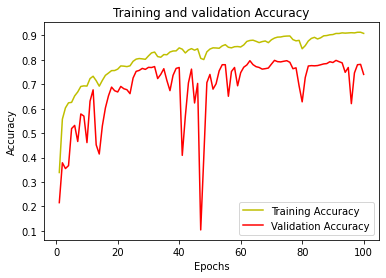

In [27]:
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
model_resnet_backbone.save('C:/Users/susha/Dropbox/My PC (LAPTOP-46V5QLMG)/Desktop/Programs/UNet/resnet_backbone.hdf5')

In [30]:
from tensorflow.keras.models import load_model
model = load_model('C:/Users/susha/Dropbox/My PC (LAPTOP-46V5QLMG)/Desktop/Programs/UNet/resnet_backbone.hdf5')

In [31]:
# making predictions...
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

3/3 [==============================] - 3s 603ms/step


In [33]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 93ms/step


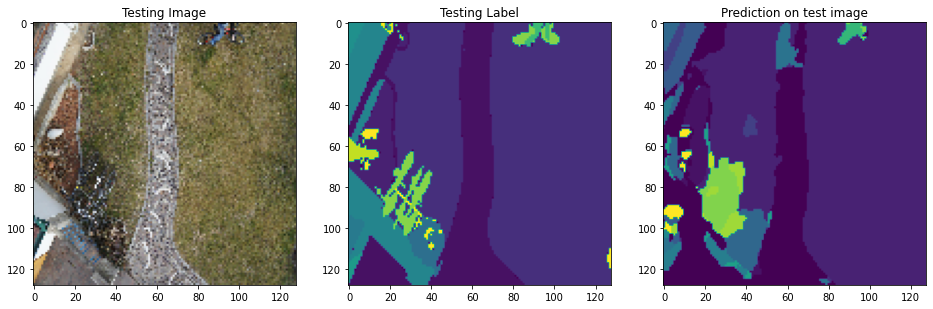

In [34]:
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()